In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from collections import deque
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

## interactive map 
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
## 사진 데이터 로드 
pic_ds = pd.read_pickle('./resource/pic_ds.pkl')
pic_ds.sort('datetime', inplace=True)

* kmeans로 위치 정보 clustering

In [3]:
from colour import Color
sns.set(style="whitegrid", palette="colorblind", font_scale=1.4, rc={'font.family':'NanumGothic'} )

In [192]:
def distance(pos1, pos2):
    return abs(pos1[0]-pos2[0]) + abs(pos1[1]-pos2[1])

2

In [193]:
## Map 관련 함수들 

def pos2bound(pos, tune_val=(0,0,-.05, -0.08)  ):
    return [ (pos[0] + tune_val[0] , pos[1] + tune_val[1]),
             (pos[0] + tune_val[2] , pos[1] + tune_val[3]) ]

def pos2bound_by_wh(pos, height, width ):
    y = -.01
    x = .01
    return pos2bound( pos, (y, x, y - height, x + width) )


def addImage(filename, pos, width=.08, height=.05):
    img_url = "http://localhost:8888/files/photo-analysis/resource/small-photo/%s" % filename
    bounds = pos2bound_by_wh(pos, height, width)
    io = ImageOverlay(url=img_url, bounds=bounds, opacity=.6 )
    m.add_layer(io)
    return io



def addImages(ds, enable_tracking=False):
    old_pos = (0,0)
    for idx, row in ds.iterrows():
        if (distance(old_pos, (row.latitude, row.longitude)) > 1) & enable_tracking:
            old_pos = (row.latitude, row.longitude)
            m.center = old_pos
        addImage(row.image_name, (row.latitude, row.longitude))
    
    
def drawMarker(pos_list):
    Markeres = []
    for pos in pos_list:
        c = Marker(location=(pos[0],pos[1]), color='#0F0'
                  ,opacity=.7 )
        
        Markeres.append(c)
        m.add_layer(c)
    return Markeres

## lat, lng, radius, fill_color, fill_opacity
def drawCircles(pos_list):
    circles = []
    for pos in pos_list:
        c = Circle(location=(pos[0],pos[1]), radius=pos[2], weight=1, fill_color=pos[3]
                  ,opacity=.5, fill_opacity=pos[4],color=pos[3] )
        
        circles.append(c)
        m.add_layer(c)
    return circles

## lat, lng, radius, fill_color, fill_opacity
def drawCirclesByDF(ds, lat='lat', lng='lng', radius='size', color='color', fill_opacity='opacity'):
    circles = []
    for (idx, row) in ds.iterrows():
        c = Circle( location=(row[lat], row[lng])
                   , radius=row[radius]
                   , weight=1
                   , fill_color= row[color]
                   , opacity=.7
                   , fill_opacity=fill_opacity if type(fill_opacity) in (float, int) else row[fill_opacity]
                   , color=row[color] )
        
        circles.append(c)
        m.add_layer(c)
    return circles


def removeCircles(circles):
    for c in circles[:]:
        try:
            m.remove_layer(c)        
        except :
            pass 

def animateHistorie():
    circles = []
    images = deque()
    old_center = [0,0]
    seq = 0

    for info in location_infos:
        cinfo = cid_info[info[3]]

        ## 동그라미 그리고 
        c = Circle(location=(info[1],info[2]), radius=cinfo[1], weight=1, fill_color=info[6]
                  ,  opacity=.1, fill_opacity=cinfo[0] )
        circles.append(c)
        m.add_layer(c)

        ## image 그리고 
        io = addImage(info[0], (info[1],info[2]))
        
        ## 이동하고 
        center = [info[4],info[5]]
        if old_center != center:
            m.center = center
            m.zoom = cinfo[2]
            #time.sleep(1.5)
            old_center = center
        else :
            ## 잠시 쉬고 
            time.sleep(.1)  
            pass
def addYearLabel(filename, old_io=None):
    if old_io is not None:
        try:
            m.remove_layer(old_io)
        except:
            pass
    
    img_url = "http://localhost:8888/files/photo-analysis/resource/small-photo/%s" % filename
    pos = (m.bounds[0][0]+.06, m.bounds[0][1]+.0)
    bounds = pos2bound_by_wh(pos, .05, .15)
    io = ImageOverlay(url=img_url, bounds=bounds, opacity=.5 )
    m.add_layer(io)
    return io        

In [7]:


def geoClustering(ds, key='image_name', lat='latitude', lng='longitude', k=100 ):
## generate data by clustered location
    positions = [[row[lat], row[lng]] for idx, row in ds.iterrows()]
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=13)
    k_means.fit(positions)
    cluster_info = pd.DataFrame(k_means.labels_,columns=['cid'])
    
    clustered_info = []
    for cid in k_means.labels_:
        info = [cid]
        info.extend(k_means.cluster_centers_[cid].tolist())
        clustered_info.append(info)
    return pd.DataFrame(clustered_info, columns=['cid','cid_lat', 'cid_lng'])
    

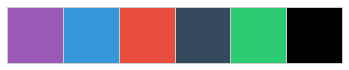

In [8]:
## year palette 
pal = ["#9b59b6", "#3498db",  "#e74c3c", "#34495e", "#2ecc71",'#000000']
sns.palplot(pal)
year_pal = {  year:col for year,col in zip(range(2012,2017),pal) }

## 기본 데이터 생성 
geo_pic_ds = pic_ds[(pic_ds.latitude>0)]
geo_pic_ds['color'] = geo_pic_ds.year.apply(lambda x: year_pal.get(x,'#000'))
geo_pic_ds.reset_index(drop=True, inplace=True)
clustered = geoClustering(geo_pic_ds, 50)
geo_pic_ds = pd.concat([geo_pic_ds, clustered], axis=1, join_axes=[geo_pic_ds.index])


In [9]:
""" 
location_infos = []
for (seq, (idx, row)) in enumerate(pic_ds[(pic_ds.latitude>0)][:].iterrows()):
    cluster_id = k_means.labels_[seq]
    cluster_center = k_means.cluster_centers_[cluster_id].tolist()
    info = [
        row.image_name,
        row.latitude, row.longitude,
        cluster_id,
        cluster_center[0], cluster_center[1],
        pal[cluster_id],
        row.year
    ]
    location_infos.append(info)

location_info_ds = pd.DataFrame(location_infos, columns='image_name pos_lat pos_lng cid cid_lat cid_lng color year'.split())
cid_cnt_ds = location_info_ds.groupby('cid').count()[['image_name']]

cid_info = {}
for cid, row in cid_cnt_ds.iterrows():
    info = []
    if row.image_name > 100:
        cid_info[cid] = [0.1, 600, 11]
    elif row.image_name > 10:
        cid_info[cid] = [0.2, 1000, 11]
    else :
        cid_info[cid] = [0.5, 1000, 11]
"""        

" \nlocation_infos = []\nfor (seq, (idx, row)) in enumerate(pic_ds[(pic_ds.latitude>0)][:].iterrows()):\n    cluster_id = k_means.labels_[seq]\n    cluster_center = k_means.cluster_centers_[cluster_id].tolist()\n    info = [\n        row.image_name,\n        row.latitude, row.longitude,\n        cluster_id,\n        cluster_center[0], cluster_center[1],\n        pal[cluster_id],\n        row.year\n    ]\n    location_infos.append(info)\n\nlocation_info_ds = pd.DataFrame(location_infos, columns='image_name pos_lat pos_lng cid cid_lat cid_lng color year'.split())\ncid_cnt_ds = location_info_ds.groupby('cid').count()[['image_name']]\n\ncid_info = {}\nfor cid, row in cid_cnt_ds.iterrows():\n    info = []\n    if row.image_name > 100:\n        cid_info[cid] = [0.1, 600, 11]\n    elif row.image_name > 10:\n        cid_info[cid] = [0.2, 1000, 11]\n    else :\n        cid_info[cid] = [0.5, 1000, 11]\n"

### 사진으로 생활권 그리기 

In [10]:
def calCentresInfo(ds):
    centres_ds = ds.groupby(['cid_lat','cid_lng','color','year'])\
        .agg({'cid':len, 'image_name':np.max}).reset_index()

    ## 사진의 중간에 점을찍고, 사이즈를 기반으로 반경을 그리고 
    max_cnt = centres_ds.cid.max()
    total = centres_ds.shape[0]
    centres_ds.cid = centres_ds.cid.apply(lambda x: x*10 + 1000)
    
    centres_ds.sort('cid',inplace=True)
    centres_ds['opacity'] = [ .2+(rank/total)*.2 for rank in range(0,total) ]
    
    #centres_ds['opacity'] = centres_ds.cid.apply(lambda x: cid*0.3/max_cnt + .2)
    return centres_ds

In [11]:
map_objects=[]
old_io=None

--- 
* 전체 나의 활동 지역

In [203]:
old_io = None
def renderMap(ds, show_circle=True, show_marker=True, show_image=False, image_width=.08, image_height=.05
             , enable_tracking=False):
    
    old_pos = (0,0)
    if show_image:
        for idx, row in ds.iterrows():
            if (distance(old_pos, (row.cid_lat, row.cid_lng)) > 1) & enable_tracking:
                old_pos = (row.cid_lat, row.cid_lng)
                m.center = old_pos
                time.sleep(1.)
            addImage(row.image_name, (row.cid_lat, row.cid_lng), width=image_width, height=image_height)
    map_objects = []
    
    if show_circle:
        map_objects.extend(drawCircles(ds[['cid_lat','cid_lng','cid','color','opacity']].values) )
    if show_marker:
        map_objects.extend(drawMarker(ds[['cid_lat','cid_lng','cid','color','opacity']].values) )

    return map_objects

def renderYearlyMap(ds, remove=False, show_image=False):
    global old_io, map_objects
    for year in range(2012, 2017):
        if remove: removeCircles(map_objects)
        old_io = addYearLabel('%db.png' % year, old_io=old_io)
        tmp_ds = ds[ds.year==year]
        tmp_ds['color'] = year_pal[year]
        map_objects = renderMap(tmp_ds, show_image=show_image)
        time.sleep(2)



In [98]:
m = Map(center=[37.414161,127.137560 ], zoom=11, height='600px')

In [99]:
m

In [100]:
## 년단위 전체 
centres_ds = calCentresInfo(geo_pic_ds)
renderYearlyMap(centres_ds, remove=False, show_image=False)

In [ ]:
### 정기 휴가는 어디로 갔을까?

In [36]:
m = Map(center=[37.414161,127.137560 ], zoom=7, height='650px')
m

In [32]:
centres_ds = calCentresInfo(geo_pic_ds[geo_pic_ds['class']=='정기휴가'])
a = renderMap(centres_ds, show_image=True, image_height=.65, image_width=1.2)

In [43]:
m = Map(center=(15.873494,108.203103), zoom=11, height='650px')
m

In [44]:
centres_ds = calCentresInfo(geo_pic_ds[geo_pic_ds['class']=='정기휴가'])
a = renderMap(centres_ds, show_image=True )

In [86]:
geo_pic_ds.g

,0,1,2,3,4
image_name,IMG_0958.JPG,IMG_0979.JPG,IMG_0984.JPG,IMG_0596.JPG,IMG_0963.JPG
datetime,2012-03-23 18:53:24,2012-03-28 07:55:41,2012-03-28 07:58:25,2012-03-30 19:08:29,2012-03-30 19:09:23
latitude,37.40967,37.41217,37.414,37.412,37.41217
longitude,127.1343,127.1422,127.1378,127.1322,127.1322
model,iPhone 4S,iPhone 4S,iPhone 4S,iPhone 4S,iPhone 4S
resolution,480X640,480X640,480X640,2448X3264,480X640
year,2012,2012,2012,2012,2012
year_day,83.78681,88.32986,88.33194,90.79722,90.79792
date,2012-03-23,2012-03-28,2012-03-28,2012-03-30,2012-03-30
addr,경기도_성남시_분당구_야탑3동,경기도_성남시_분당구_야탑3동,경기도_성남시_분당구_야탑3동,경기도_성남시_분당구_야탑1동,경기도_성남시_분당구_야탑1동


In [89]:
place_ds = geo_pic_ds[geo_pic_ds['class']=='정기휴가']\
    .groupby('place')\
    .agg({'date': lambda x: len(np.unique(x)), 'image_name':len})\
    .sort('date',ascending=False)
place_ds.columns = ['사진수', '방문일수']
place_ds

,사진수,방문일수
place,,
베트남_팜비치,72,3
제주도,10,3
베트남_다낭미케해변,19,3
베트남_호이안시가지,96,2
김포_공항,1,1
전주_한옥마을,2,1
인천_공항,25,1
속초_대명,5,1
분당_,7,1


In [47]:
m = Map(center=[37.414161,127.137560 ], zoom=11, height='600px')
m

In [48]:
centres_ds = calCentresInfo(geo_pic_ds[geo_pic_ds['class']=='캠핑'])
a = renderMap(centres_ds, show_image=True )

In [49]:
m = Map(center=[37.414161,127.137560 ], zoom=11, height='600px')
m

In [50]:
centres_ds = calCentresInfo(geo_pic_ds[geo_pic_ds['class']=='나들이'])
a = renderMap(centres_ds, show_image=True )

In [51]:
m = Map(center=[37.414161,127.137560 ], zoom=11, height='600px')
m

In [52]:
centres_ds = calCentresInfo(geo_pic_ds[geo_pic_ds['class']=='캠핑'])
a = renderMap(centres_ds, show_image=True )

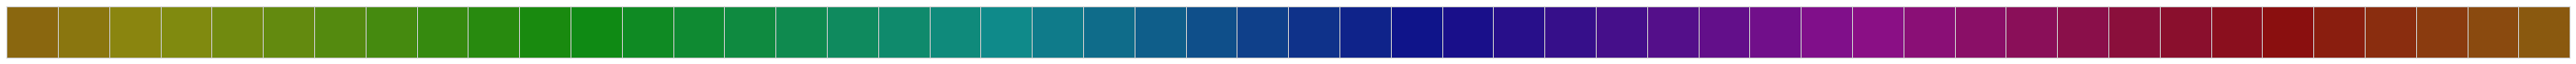

In [35]:
## 50개의 클러스터로 구성
n_clusters = 50
pal = sns.hls_palette(n_clusters, l=.3, s=.8, h=.12).as_hex()
sns.palplot(pal)
## generate data 
positions = [ [row.latitude, row.longitude] for idx, row in pic_ds[(pic_ds.latitude>0)][:].iterrows()]
random.seed(0)
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, random_state=13)
k_means.fit(positions)

cluster_labels = pd.DataFrame(k_means.labels_,columns=['cid'])

location_infos = []
for (seq, (idx, row)) in enumerate(pic_ds[(pic_ds.latitude>0)][:].iterrows()):
    cluster_id = k_means.labels_[seq]
    cluster_center = k_means.cluster_centers_[cluster_id].tolist()
    info = [
        row.image_name,
        row.latitude, row.longitude,
        cluster_id,
        cluster_center[0], cluster_center[1],
        pal[cluster_id],
        row.year
    ]
    location_infos.append(info)

location_info_ds = pd.DataFrame(location_infos, columns='image_name pos_lat pos_lng cid cid_lat cid_lng color year'.split())
cid_cnt_ds = location_info_ds.groupby('cid').count()[['image_name']]

cid_info = {}
for cid, row in cid_cnt_ds.iterrows():
    info = []
    if row.image_name > 100:
        cid_info[cid] = [0.1, 600, 11]
    elif row.image_name > 10:
        cid_info[cid] = [0.2, 1000, 10]
    else :
        cid_info[cid] = [0.5, 1000, 10]
        

In [38]:
m = Map(center=[37.041347222222225, 127.59707777777777 ], zoom=10)
m.layout.height='600px'
m

In [37]:
animateHistorie()

In [ ]:
centres_ds = calCentresInfo(geo_pic_ds[geo_pic_ds['class']=='정기휴가'])
a = renderMap(centres_ds, show_image=True )

In [ ]:
### 
### 
* 베트남 여행 루트
* 2015년 휴가 여행 루트 

#### 참조 'cid_lat','cid_lng','cid','color','opacity' 

In [160]:
# 베트남_다낭시내
vn_pic_ds = geo_pic_ds[geo_pic_ds.place.apply(lambda x: x.find(u"베트남_")>-1)]
vn_pic_ds['opacity'] = .2
vn_pic_ds['cid'] = 1000
vn_pic_ds['color'] = vn_pic_ds.date.apply(lambda x:pal[x.day%(pal_size)])

In [175]:
m = Map(center=[15.965290084132517, 108.30390930175781], zoom=11, height='600px')
m

In [176]:
layout_list = renderMap(vn_pic_ds, show_image=True, show_marker=False)

In [123]:
# 베트남_다낭시내
trip2015_pic_ds = geo_pic_ds[geo_pic_ds.place.apply(lambda x: x.find(u"베트남_")>-1)]
vn_pic_ds['opacity'] = .2
vn_pic_ds['cid'] = 1000
vn_pic_ds['color'] = vn_pic_ds.date.apply(lambda x:pal[x.day%(pal_size)])

" \ndef calCentresInfo(ds):\n    centres_ds = ds.groupby(['cid_lat','cid_lng','color','year'])        .agg({'cid':len, 'image_name':np.max}).reset_index()\n\n    ## 사진의 중간에 점을찍고, 사이즈를 기반으로 반경을 그리고 \n    max_cnt = centres_ds.cid.max()\n    total = centres_ds.shape[0]\n    centres_ds.cid = centres_ds.cid.apply(lambda x: x*10 + 1000)\n    \n    centres_ds.sort('cid',inplace=True)\n    centres_ds['opacity'] = [ .2+(rank/total)*.2 for rank in range(0,total) ]\n    \n    #centres_ds['opacity'] = centres_ds.cid.apply(lambda x: cid*0.3/max_cnt + .2)\n    return centres_ds\n"

In [199]:
junior_pic_ds = geo_pic_ds[(geo_pic_ds.junior_age > 0)&(geo_pic_ds.person==1)]
junior_pic_ds['opacity'] = .2
junior_pic_ds['cid'] = 1000
junior_pic_ds['color'] = junior_pic_ds.cid.apply(lambda x:pal[x%(pal_size)])

In [212]:
m = Map(center=[37.414161,127.137560 ], zoom=11, height='600px')
m

In [213]:
layout_list = renderMap(junior_pic_ds, show_image=True, show_marker=False, show_circle=False, enable_tracking=True)